In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat
from skimage import color
from skimage import io
from sklearn.model_selection import train_test_split
import cv2

%matplotlib inline
plt.rcParams['figure.figsize'] = (16.0, 4.0)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip gdrive/My\ Drive/train.zip > /dev/null

In [ ]:
def load_data(path):
    data = loadmat(path)
    return data['X'], data['y']

X_train, y_train = load_data('train.mat')
X_test, y_test = load_data('test.mat')

In [ ]:
xtrain, ytrain = X_train.transpose((3,0,1,2)), y_train[:,0]
xtest, ytest = X_test.transpose((3,0,1,2)), y_test[:,0]

num_images = X_train.shape[0] + X_test.shape[0]

In [ ]:
def plot_images(img, labels, nrows, ncols):
    """ Plot nrows x ncols images
    """
    fig, axes = plt.subplots(nrows, ncols)
    for i, ax in enumerate(axes.flat): 
        if img[i].shape == (32, 32, 3):
            ax.imshow(img[i])
        else:
            ax.imshow(img[i,:,:,0])
        ax.set_xticks([]); ax.set_yticks([])
        ax.set_title(labels[i])

/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


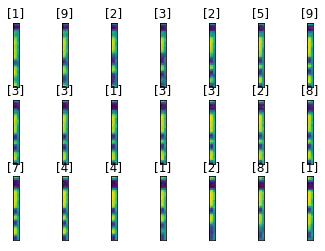

In [ ]:
# Plot some training set images
plot_images(X_train, y_train, 3,7)

/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


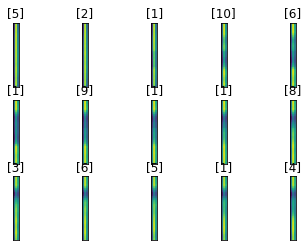

In [ ]:
# Plot some test set images
plot_images(X_test, y_test, 3, 5)

In [ ]:
print(np.unique(y_train))

[ 1  2  3  4  5  6  7  8  9 10]


In [ ]:
def rgb2gray(images):
    return np.expand_dims(np.dot(images, [0.2990, 0.5870, 0.1140]), axis=3)

In [ ]:
train_greyscale = rgb2gray(xtrain).astype(np.float32)
test_greyscale = rgb2gray(xtest).astype(np.float32)

In [ ]:
train = np.ones([len(train_greyscale),32, 128]) * 255
c=-1
newSize=(128,32)
for i in train_greyscale: 
    c=c+1
    img = cv2.resize(train_greyscale[c], (128,32))
    train[c,0:newSize[1], 0:newSize[0]] = img

In [ ]:
test = np.ones([len(test_greyscale),32, 128]) * 255
c=-1
newSize=(128,32)
for i in test_greyscale: 
    c=c+1
    img = cv2.resize(test_greyscale[c], (128,32))
    test[c,0:newSize[1], 0:newSize[0]] = img

In [ ]:
train_mean = np.mean(train, axis=0)

train_std = np.std(train, axis=0)

train_greyscale_norm = (train  - train_mean) / train_std
test_greyscale_norm = (test  - train_mean)  / train_std

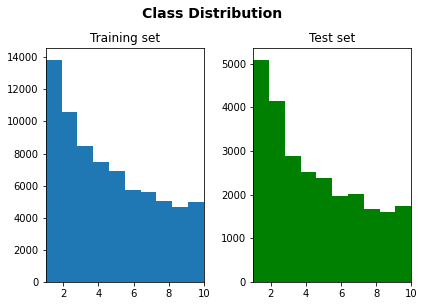

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True)

fig.suptitle('Class Distribution', fontsize=14, fontweight='bold', y=1.05)

ax1.hist(y_train, bins=10)
ax1.set_title("Training set")
ax1.set_xlim(1, 10)

ax2.hist(y_test, color='g', bins=10)
ax2.set_title("Test set")

fig.tight_layout()

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(train_greyscale_norm,ytrain, test_size=0.25, random_state=43)

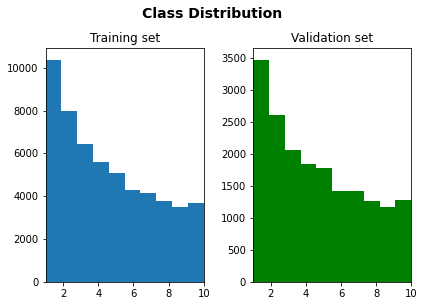

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True)

fig.suptitle('Class Distribution', fontsize=14, fontweight='bold', y=1.05)

ax1.hist(y_train, bins=10)
ax1.set_title("Training set")
ax1.set_xlim(1, 10)

ax2.hist(y_val, color='g', bins=10)
ax2.set_title("Validation set")

fig.tight_layout()

In [ ]:
y_train.shape, y_val.shape, y_test.shape

((54942,), (18315,), (26032, 1))

In [ ]:
del train_greyscale_norm,train,test,train_std,train_mean

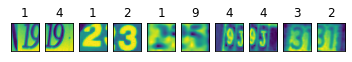

In [ ]:
plot_images(train_greyscale, y_train, 1, 10)

In [ ]:
from sklearn.preprocessing import OneHotEncoder
 
enc = OneHotEncoder().fit(y_train.reshape(-1, 1))

y_train = enc.transform(y_train.reshape(-1, 1)).toarray()
y_test = enc.transform(y_test.reshape(-1, 1)).toarray()
y_val = enc.transform(y_val.reshape(-1, 1)).toarray()


In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,Dropout,LSTM,Reshape,BatchNormalization
from keras.regularizers import l2

model=Sequential()

conv1 =model.add(Conv2D(32, 3, strides=1, activation="ReLU", padding="same",input_shape=(32,128,1)))

conv2=model.add(Conv2D(32, 3, strides=1, activation="ReLU", padding="same",input_shape=(32,32,1)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2), name="pool1"))
model.add(Dropout(0.3))

conv3=model.add(Conv2D(64,kernel_size=3,strides=1,activation="ReLU",padding="same"))

conv4=model.add(Conv2D(64,kernel_size=3,strides=1,activation="ReLU",padding="same",kernel_regularizer=l2(0.0005)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2), name="pool2"))
model.add(Dropout(0.3))

conv5=model.add(Conv2D(128,kernel_size=3,strides=1,activation="ReLU",padding="same"))
model.add(BatchNormalization())
#model.add(Dropout(0.2))

conv6=model.add(Conv2D(128,kernel_size=3,strides=1,activation="ReLU",padding="same",kernel_regularizer=l2(0.0005)))
model.add(BatchNormalization())

model.add(MaxPooling2D((2, 2), name="pool3"))
model.add(Dropout(0.3))


model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dense(256,activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(256,activation="relu"))
model.add(Dense(256,activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(10,activation="softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 128, 32)       320       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 128, 32)       9248      
                                                                 
 batch_normalization (BatchN  (None, 32, 128, 32)      128       
 ormalization)                                                   
                                                                 
 pool1 (MaxPooling2D)        (None, 16, 64, 32)        0         
                                                                 
 dropout (Dropout)           (None, 16, 64, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 64, 64)        18496     
                                                        

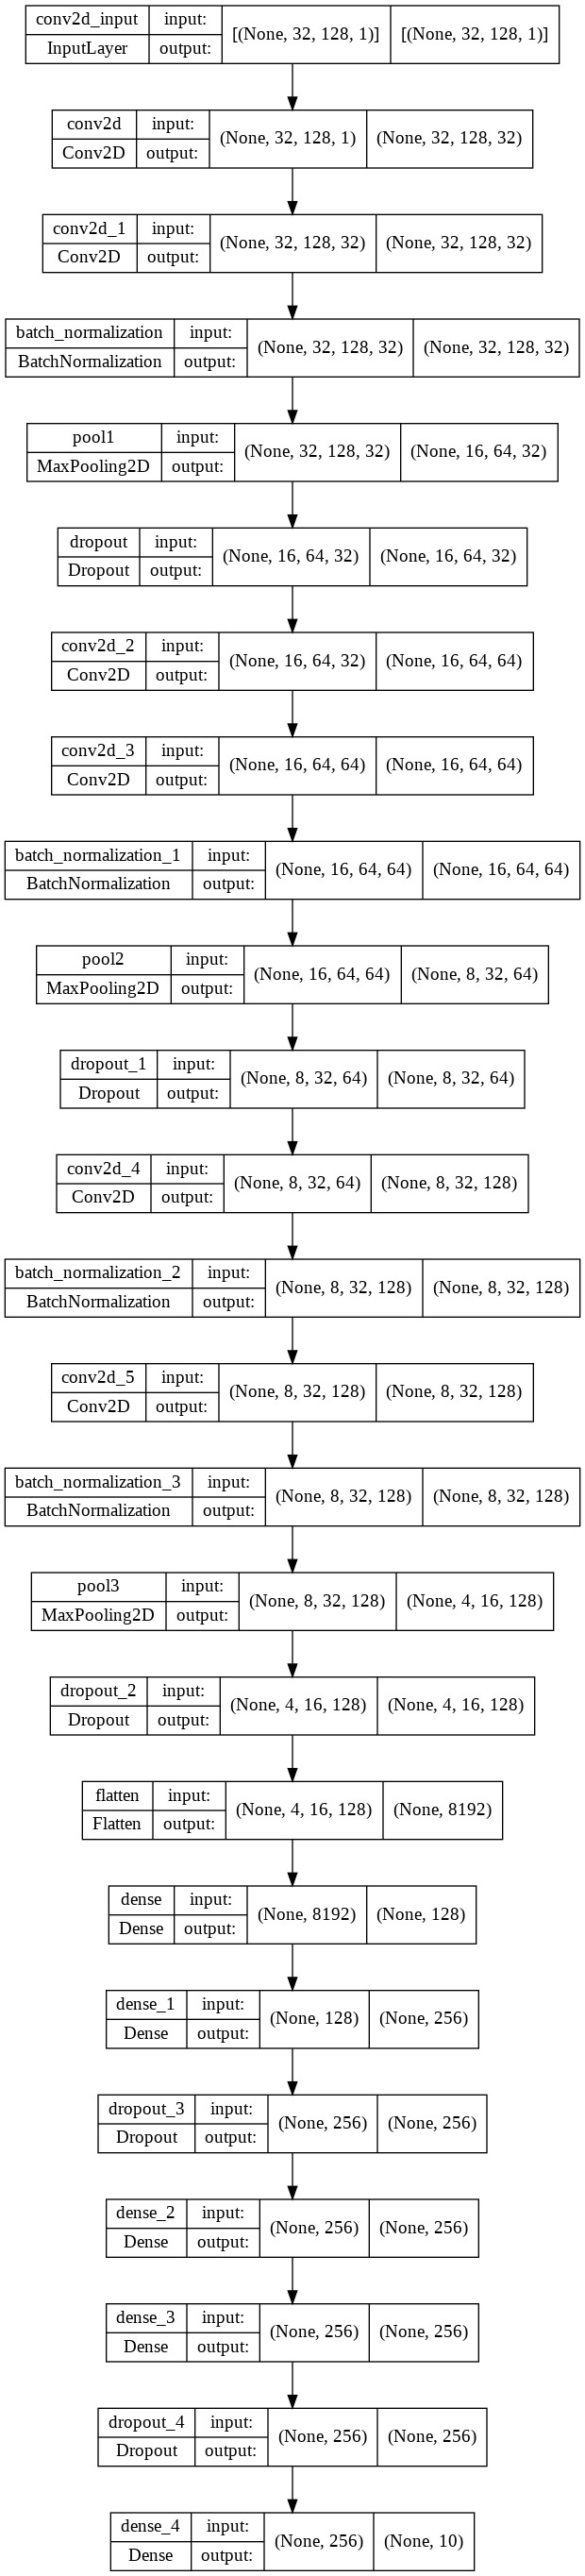

In [ ]:
from tensorflow import keras
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
#from tensorflow import keras
early_stopping = keras.callbacks.EarlyStopping(patience=8,min_delta=0.001)
optimizer = keras.optimizers.Adam(learning_rate=1e-4, amsgrad=True)
model_checkpoint = keras.callbacks.ModelCheckpoint('/kaggle/working/best_cnn.h5', save_best_only=True)
model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, batch_size=128,epochs=30, validation_data=(X_val, y_val),callbacks=[early_stopping, model_checkpoint])

Epoch 1/30
430/430 [==============================] - 39s 59ms/step - loss: 2.2028 - accuracy: 0.2417 - val_loss: 1.8817 - val_accuracy: 0.4181
Epoch 2/30
430/430 [==============================] - 23s 54ms/step - loss: 1.2844 - accuracy: 0.6028 - val_loss: 0.7962 - val_accuracy: 0.7731
Epoch 3/30
430/430 [==============================] - 24s 55ms/step - loss: 0.8218 - accuracy: 0.7728 - val_loss: 0.6042 - val_accuracy: 0.8431
Epoch 4/30
430/430 [==============================] - 24s 55ms/step - loss: 0.6712 - accuracy: 0.8238 - val_loss: 0.5475 - val_accuracy: 0.8627
Epoch 5/30
430/430 [==============================] - 24s 55ms/step - loss: 0.5937 - accuracy: 0.8503 - val_loss: 0.5035 - val_accuracy: 0.8753
Epoch 6/30
430/430 [==============================] - 24s 55ms/step - loss: 0.5336 - accuracy: 0.8673 - val_loss: 0.4672 - val_accuracy: 0.8877
Epoch 7/30
430/430 [==============================] - 24s 55ms/step - loss: 0.4923 - accuracy: 0.8797 - val_loss: 0.4333 - val_accuracy:

In [ ]:
loss , accuracy=model.evaluate(test_greyscale_norm,y_test)
print(accuracy)
print(loss)
y_pred = model.predict(test_greyscale_norm)

814/814 [==============================] - 5s 6ms/step - loss: 0.4031 - accuracy: 0.9189
0.9188690781593323
0.40310803055763245


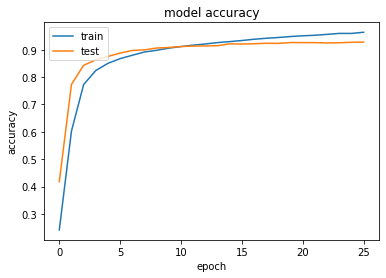

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


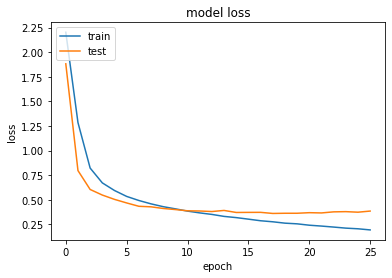

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

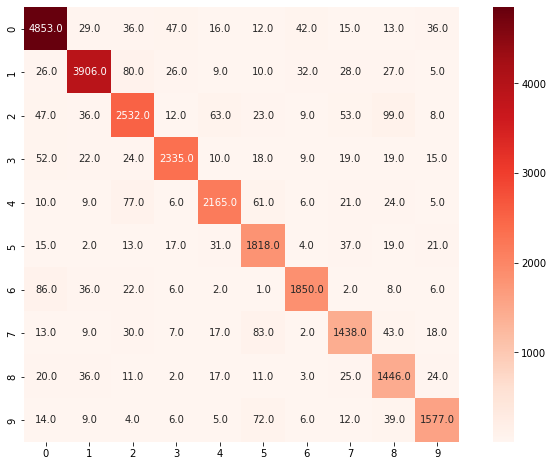

In [ ]:
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(12, 8))
predictions = model.predict(test_greyscale_norm, steps=len(test_greyscale_norm), verbose=0)

cm = confusion_matrix(y_true = np.argmax(y_test, axis=1),y_pred = np.argmax(predictions, axis=-1))


# Visualize the confusion matrix
sns.heatmap(cm, annot=True, cmap='Reds', fmt='.1f', square=True);

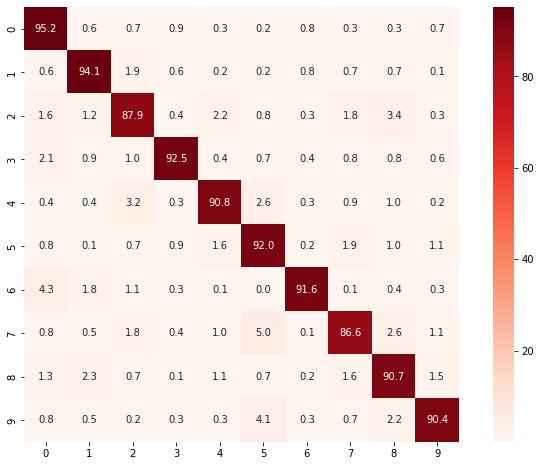

In [ ]:
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(12, 8))
predictions = model.predict(test_greyscale_norm, steps=len(test_greyscale_norm), verbose=0)

cm = confusion_matrix(y_true = np.argmax(y_test, axis=1),y_pred = np.argmax(predictions, axis=-1))

# Normalize the confusion matrix
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100.0

# Visualize the confusion matrix
sns.heatmap(cm, annot=True, cmap='Reds', fmt='.1f', square=True);

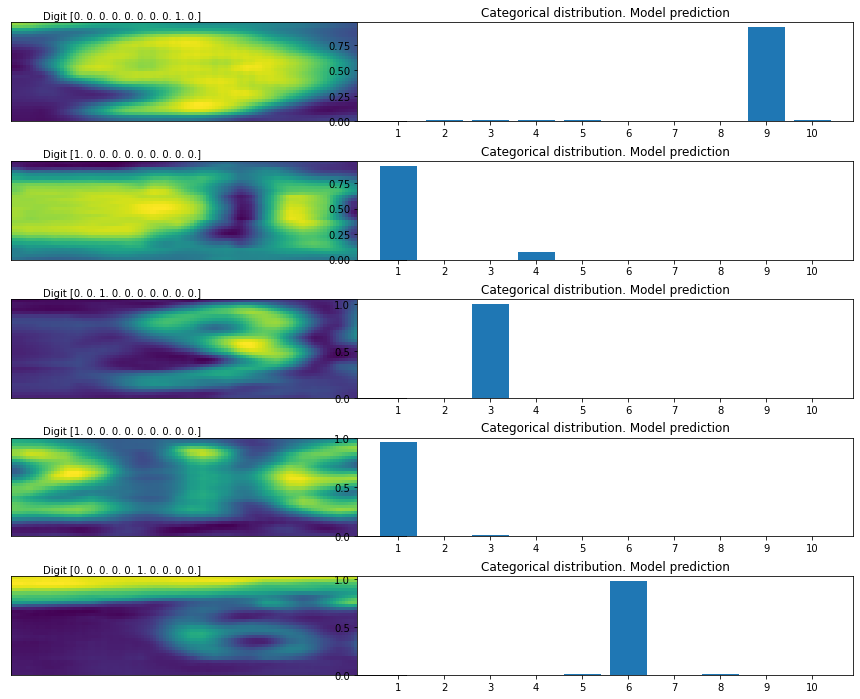

In [ ]:
num_test_images =test_greyscale_norm .shape[0]

random_inx = np.random.choice(num_test_images, 5)
random_test_images = test_greyscale_norm[random_inx, ...]
random_test_labels = y_test[random_inx, ...]

predictions = model.predict(random_test_images)

fig, axes = plt.subplots(5, 2, figsize=(16, 12))
fig.subplots_adjust(hspace=0.4, wspace=-0.2)

for i, (prediction, image, label) in enumerate(zip(predictions, random_test_images, random_test_labels)):
    axes[i, 0].imshow(np.squeeze(image))
    axes[i, 0].get_xaxis().set_visible(False)
    axes[i, 0].get_yaxis().set_visible(False)
    axes[i, 0].text(10., -1.5, f'Digit {label}')
    axes[i, 1].bar(np.arange(1,11), prediction)
    axes[i, 1].set_xticks(np.arange(1,11))
    axes[i, 1].set_title("Categorical distribution. Model prediction")
    
plt.show()